In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
df = pd.read_csv('generated_two.csv')
df.sample(n=15)

,Time,Day,Temp,Humidity,Light_Intensity,Occupancy,Energy
151,09:20,Tuesday,24.6,50.1,655,1,11.71
273,02:00,Thursday,14.9,64.2,9,0,7.74
287,06:40,Thursday,20.2,54.3,0,0,5.43
1889,12:40,Friday,23.5,46.7,990,1,10.68
1981,19:20,Saturday,18.0,67.8,8,0,4.56
1242,13:00,Wednesday,24.6,50.1,716,1,10.58
541,19:20,Sunday,19.2,65.2,3,0,4.12
1146,05:00,Tuesday,21.4,61.2,4,0,5.23
1334,19:40,Thursday,18.0,58.5,4,1,9.45
747,16:00,Wednesday,23.7,47.0,41,1,11.97


In [3]:
df.shape

(2000, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             2000 non-null   object 
 1   Day              2000 non-null   object 
 2   Temp             2000 non-null   float64
 3   Humidity         2000 non-null   float64
 4   Light_Intensity  2000 non-null   int64  
 5   Occupancy        2000 non-null   int64  
 6   Energy           2000 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 109.5+ KB


In [5]:
df['Occupancy'].value_counts()

Occupancy
0    1404
1     596
Name: count, dtype: int64

In [6]:
df.describe()

,Temp,Humidity,Light_Intensity,Occupancy,Energy
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,20.033550,59.912500,252.529500,0.298000,7.126735
std,3.817697,8.069426,316.731801,0.457494,2.483395
min,12.400000,40.400000,0.000000,0.000000,2.730000
25%,16.900000,53.600000,5.000000,0.000000,5.200000
50%,20.050000,59.700000,9.000000,0.000000,6.460000
75%,23.200000,66.300000,499.250000,1.000000,8.855000
max,27.700000,78.100000,1258.000000,1.000000,14.610000


# Preparing data

In [ ]:
# I converted time to a numerical feature (minutes since midnight)
df['Minutes'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour * 60 + pd.to_datetime(df['Time'], format='%H:%M').dt.minute

df['Minutes']

0       420
1       440
2       460
3       480
4       500
       ... 
1995      0
1996     20
1997     40
1998     60
1999     80
Name: Minutes, Length: 2000, dtype: int32

In [8]:
df = pd.get_dummies(df, columns=['Day'])

features_to_use = ['Minutes', 'Temp', 'Humidity', 'Light_Intensity', 'Occupancy'] + [col for col in df.columns if col.startswith('Day_')]
X = df[features_to_use].values
y = df['Energy'].values

In [9]:
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1))

# building the LSTM model

In [10]:
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

# Define sequence length (3 hours = 9 timestamps)
seq_length = 9
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

In [11]:
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [12]:
######################################## LSTM model Architecture ########################################

model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, X.shape[1])),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

c:\Users\Dell\anaconda3\envs\raqib\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.compile(optimizer='adam', loss='mse')  # Compile the model


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)   # early stopping to prevent overfitting


history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)
history

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0991 - val_loss: 0.0170
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0202 - val_loss: 0.0169
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0178 - val_loss: 0.0117
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0161 - val_loss: 0.0091
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0163 - val_loss: 0.0150
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0146 - val_loss: 0.0105
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0132 - val_loss: 0.0110
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0148 - val_loss: 0.0179
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0125 - val_loss: 0.0117
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0144 - val_loss: 0.0164
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0137 - val_loss: 0.0176
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

In [ ]:
y_pred_scaled = model.predict(X_test)  ################## making predictions ##################


######################## also, inverse transform predictions and actual values #######################
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


# evaluating the LSTM model

In [15]:
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100


print("\nModel Performance Metrics:")
print(f"Root Mean Square Error: {rmse:.2f} kWh")
print(f"Mean Absolute Error: {mae:.2f} kWh")
print(f"R-squared Score: {r2:.3f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")


Model Performance Metrics:
Root Mean Square Error: 1.23 kWh
Mean Absolute Error: 0.95 kWh
R-squared Score: 0.676
Mean Absolute Percentage Error: 14.86%


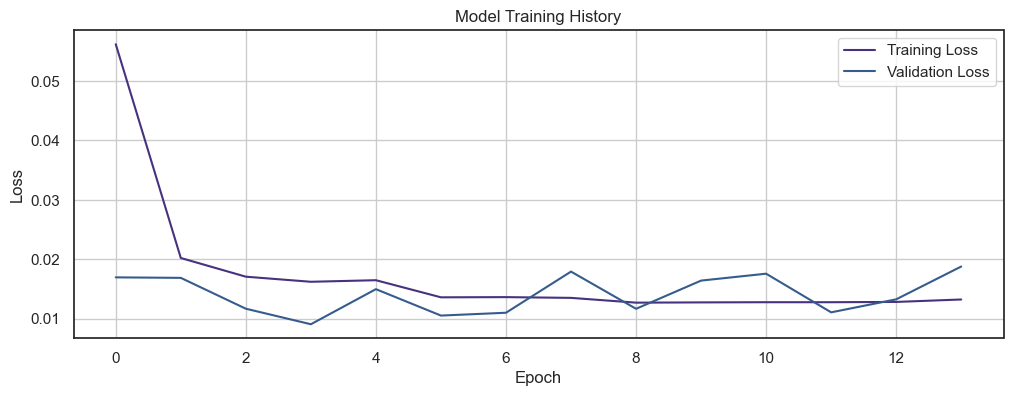

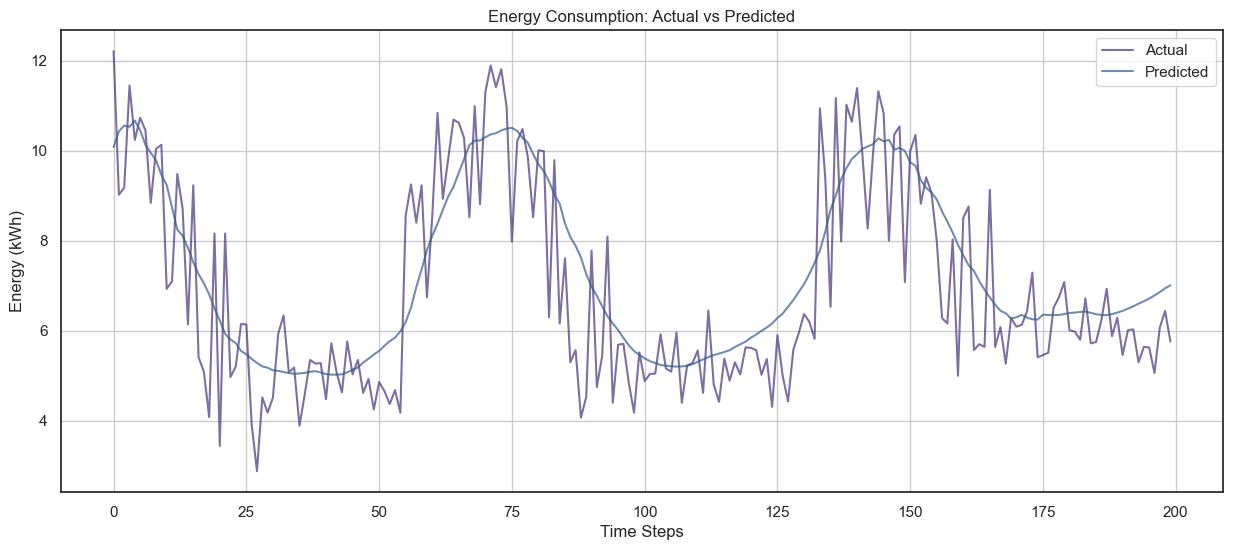

In [16]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(y_test_actual, y_pred, num_points=200):
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_actual[:num_points], label='Actual', alpha=0.7)
    plt.plot(y_pred[:num_points], label='Predicted', alpha=0.7)
    plt.title('Energy Consumption: Actual vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Energy (kWh)')
    plt.legend()
    plt.grid(True)
    plt.show()




plot_training_history(history)
plot_predictions(y_test_actual, y_pred)

In [17]:
print("Let's see further Analysis and predicton Interval:")
print(f"Average Actual Energy Consumption: {np.mean(y_test_actual):.2f} kWh")
print(f"Average Predicted Energy Consumption: {np.mean(y_pred):.2f} kWh")
print(f"Standard Deviation of Actual Values: {np.std(y_test_actual):.2f} kWh")
print(f"Standard Deviation of Predicted Values: {np.std(y_pred):.2f} kWh")

residuals = y_test_actual - y_pred
prediction_std = np.std(residuals)
confidence_interval = 1.96 * prediction_std  # 95% confidence interval
print(f"\nPrediction Interval (95% confidence): ±{confidence_interval:.2f} kWh")

Let's see further Analysis and predicton Interval:
Average Actual Energy Consumption: 6.99 kWh
Average Predicted Energy Consumption: 7.11 kWh
Standard Deviation of Actual Values: 2.16 kWh
Standard Deviation of Predicted Values: 1.77 kWh

Prediction Interval (95% confidence): ±2.40 kWh


In [20]:
import keras

In [ ]:
print('###################### saving the LSTM Model #########################')

keras.saving.save_model(model=model, filepath='first_model.keras')
print("\nModel saved as 'first_model.keras'")

###################### saving the LSTM Model #########################

Model saved as 'first_model.keras'


In [27]:
from keras.models import load_model
model = load_model('first_model.keras')
print(model.input_shape)

(None, 9, 12)
